<a href="https://colab.research.google.com/github/EvaKolosova/MachineLearningCourse/blob/master/PriceOfFlatsInMoscow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np              # Массивы (матрицы, векторы, линейная алгебра)
import matplotlib.pyplot as plt # Научная графика
import pandas as pd             # Таблицы и временные ряды (dataframe, series)
import seaborn as sns           # Еще больше красивой графики для визуализации данных
import sklearn                  # Алгоритмы машинного обучения

# Оценка стоимости квартиры в Москве

Предположим, что вы хотите продать квартиру и желаете узнать, по какой цене следует продавать, чтобы не продешевить. Или же из этой статистики можно узнать, по каким примерно ценам сечас продаются квартиры в разных районах Москвы.
Загрузим данные о ценах на квартиры (данные собраны ВШЭ для спецкурса более 2х лет назад):

In [7]:
url = "https://raw.githubusercontent.com/EvaKolosova/MachineLearningCourse/master/flats_moscow.csv"
data_raw = pd.read_csv(url)

Таблица содержит данные о ценах для 2040 квартир в г.Москве. Для каждой квартиры указаны ее цена (в 1000$), цена и некоторые переменные, такие как общая и жилая площадь, размер кухни, расстояние до центра (в км) и до метро (в минутах), также указан тип здания (1 – кирпичный, монолит ж/б, 0 – другой), этаж (1 – этаж кроме первого и последнего, 0 – иначе.) и др.

Известно, что в датасете представлены 11 признаков и данные можно разделить на 8 классов по территориальному различию. Также известно, что отсутствуют пропущенные значения, и классы несбалансированы.

Вначале посмотрим на размеры таблицы - количество строк (каждая строка соответствует одной квартире) и количество столбцов (каждый столбец соответствует конкретному признаку):

In [8]:
data_raw.shape

(2040, 11)

Отсюда видно, что в дтасете есть 11 признаков.
Метод `data_raw.head()` отображает первые строки (по умолчанию, 5 строк) таблицы

In [9]:
data_raw.head()

,Unnamed: 0,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
0,1,81,58,40,6.0,12.5,7,1,1,1,3
1,2,75,44,28,6.0,13.5,7,1,0,1,6
2,3,128,70,42,6.0,14.5,3,1,1,1,3
3,4,95,61,37,6.0,13.5,7,1,0,1,1
4,5,330,104,60,11.0,10.5,7,0,1,1,3


А вот последние строки:

In [10]:
data_raw.tail()

,Unnamed: 0,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
2035,2036,110,77,45,10.0,12.0,5,0,0,1,5
2036,2037,95,60,43,6.0,9.0,5,0,0,1,4
2037,2038,95,60,46,5.0,10.5,5,1,0,1,7
2038,2039,129,76,48,10.0,12.5,5,0,0,1,3
2039,2040,103,64,45,7.0,15.5,5,1,0,1,1


Мы видим, что столбцы (признаки) имеют следующие имена:

- `price` - цена (в тыс. долларов.)
- `totalsp` - общая площадь квартиры (в кв.м)
- `livesp` - жилая площадь квартиры (в кв.м)
- `kitsp` - площадь кухни (в кв.м)
- `dist` - расстояние от центра в км.
- `metrdist` - расстояние до метро в минутах
- `walk` - тип передвижения (1 – пешком от метро, 0 – на транспорте)
- `brick` - тип строения здания (1 – кирпичный, монолит ж/б, 0 – другой)
- `floor` - номер этажа (1 – этаж кроме первого и последнего, 0 – иначе)
- `code` - число от 1 до 8, при помощи которого мы группируем наблюдения по территориальным подвыборкам (это и будут наши 8 классов данных, с которыми мы будем работать): 
1. Наблюдения сгруппированы на севере, вокруг Калужско-Рижской линии метрополитена 
2. Север, вокруг Серпуховско-Тимирязевской линии метрополитена 
3. Северо-запад, вокруг Замоскворецкой линии метрополитена 
4. Северо-запад, вокруг Таганско-Краснопресненской линии метрополитена 
5. Юго-восток, вокруг Люблинской линии метрополитена 
6. Юго-восток, вокруг Таганско-Краснопресненской линии метрополитена 
7. Восток, вокруг Калиниской линии метрополитена 
8. Восток, вокруг Арбатско-Покровской линии метрополитена

Признаки `walk`, `brick`, `floor` и `code` - номинальные (категориальные), но представленные в числовом виде, остальные признаки (включая целевой признак `price`) - количественные (числовые).

Требуется предсказать категориальный признак `code`, представленный в числовом виде с номером типа по остальным признакам. Это *задача классификации*.

Имена столбцов (признаков) можно получить таким образом:

In [11]:
data_raw.columns

Index(['Unnamed: 0', 'price', 'totsp', 'livesp', 'kitsp', 'dist', 'metrdist',
       'walk', 'brick', 'floor', 'code'],
      dtype='object')

Имена строк (совпадают с номерами)

In [12]:
data_raw.index

RangeIndex(start=0, stop=2040, step=1)

### Доступ к отдельным элементам и выделение подтаблиц (slice)

  Cпособ доступа    |      Элемент  | Подтаблица
 ------------------ | ------------- | -----------
  Доступ по имени   | `at`, `loc`   | `loc`
  Доступ по номеру  | `iat`, `iloc` | `iloc`


In [14]:
data_raw.at[2, 'price']

128

In [15]:
data_raw.loc[2, 'price']

128

In [18]:
data_raw.iat[2, 1]

128

In [19]:
data_raw.iloc[2, 1]

128

### Подтаблицы

`loc` и `iloc` (но не `at` и `iat`) позволяют выделять не только отдельные элементы, но и подтаблицы (slice)

In [20]:
data_raw.loc[[2,3,5], ['price', 'livesp', 'kitsp']]

,price,livesp,kitsp
2,128,42,6.0
3,95,37,6.0
5,137,50,9.0


In [21]:
data_raw.iloc[[2,3,5], [1,3,4]]

,price,livesp,kitsp
2,128,42,6.0
3,95,37,6.0
5,137,50,9.0


In [22]:
data_raw.loc[[2,3,5], ['price', 'livesp', 'kitsp']].loc[5, 'kitsp']

9.0

### Целые строки или столбцы:

In [24]:
data_raw.loc[:, ['price', 'livesp']] 

,price,livesp
0,81,40
1,75,28
2,128,42
3,95,37
4,330,60
...,...,...
2035,110,45
2036,95,43
2037,95,46
2038,129,48


In [25]:
data_raw.loc[[2, 5], :] # или data_raw.loc[[2, 5], ] или data_raw.loc[[2, 5]]

,Unnamed: 0,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
2,3,128,70,42,6.0,14.5,3,1,1,1,3
5,6,137,76,50,9.0,11.0,7,1,1,1,8


## 2. Боремся с выбросами (outliers)

Понятно, что цена квартиры в первую очередь зависит от ее площади.
Построим поэтому диаграмму рассеивания для двух признаков: `price` и `totalsp`.


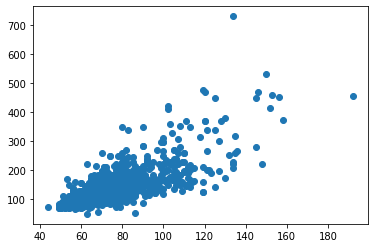

In [28]:
plt.scatter(data_raw['totsp'], data_raw['price'])
pass

Мы видим, что основная масса точек стремится к левому нижнему углу. Но в целом значения сгруппированно разбросаны по площади (ось абсцисс) от ~50 до 100 кв. м., при этом цены варьируются от примерно 50 до 200 тысяч долларов. Какие-то точки соответствуют квартирам с чрезмерно большими значениями цены или площади. Например, более $700$ тысяч долларов или с площадью более 200 кв. м.. Это *выбросы* (*outliers*) - объекты, значения признаков которых сильно отличаются от признаков основной массы объектов, сильно выпадающих из общей картины. Возможно, это ошибки в данных. В данном конкретном случае это скорее редкие данные, которые отличаются от остального множества данных, ведь рассмотрена лишь малая часть продающихся в Москве квартир. В любом случае выбросы, как правило, мешают построить хорошее решающее правило и их рекомендуется выбрасывать.

Для обнаружения выбросов найдем, например, квантили для признаков `price` и `totsp`:

In [29]:
data_raw['price'].quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])

0.005     72.000
0.010     73.000
0.050     80.000
0.100     85.000
0.500    115.000
0.900    177.100
0.950    210.000
0.990    351.220
0.995    419.025
Name: price, dtype: float64

Мы видим, например, что $99.9\%$ всех значений признака `'price'` находится в диапазоне от $72$ до $419$ тысяч долларов. (это значения квантилей, соответствующих уровням $0.005$ и $0.995$ соотвтетственно)

In [30]:
data_raw['totsp'].quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])

0.005     50.000
0.010     51.000
0.050     55.000
0.100     57.000
0.500     73.500
0.900     88.000
0.950    101.000
0.990    127.610
0.995    135.805
Name: totsp, dtype: float64

$99.9\%$ всех значений `'totsp'` находится в диапазоне от $50$ до $135$ кв. м. 

Удалим все строки таблицы, в которых `'price'` или `'totsp'` выходят за пределы квантилей $0.005$, $0.995$.

In [31]:
rows_to_drop = data_raw[
    (data_raw['price'] < data_raw['price'].quantile(0.005)) | (data_raw['price'] > data_raw['price'].quantile(0.995)) | 
    (data_raw['totsp']  < data_raw['totsp' ].quantile(0.005)) | (data_raw['totsp']  > data_raw['totsp' ].quantile(0.995))].index
data = data_raw.drop(rows_to_drop)
data.shape

(2010, 11)

 Таких значений оказалось ровно 30, так как изначально было 2040 строк данных, теперь же осталось 2010. Далее приведены индексы изьятых значений.

In [32]:
rows_to_drop

Int64Index([   1,   25,   28,   35,  101,  138,  150,  174,  265,  377,  624,
             769,  870,  885,  966, 1055, 1125, 1141, 1295, 1342, 1504, 1528,
            1533, 1656, 1673, 1679, 1813, 1930, 1940, 1958],
           dtype='int64')

## 3. Визуализация и описательная статистика

Визуализация и описательная статистика - важные этапы анализа данных.
Сводную информацию о признаках можем получить, вызвав метод `describe`:

In [33]:
data.describe()

,Unnamed: 0,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
count,2010.000000,2010.000000,2010.000000,2010.000000,2010.000000,2010.000000,2010.000000,2010.000000,2010.000000,2010.000000,2010.000000
mean,1021.497512,125.483085,72.648259,46.111940,8.855721,11.022289,8.122886,0.685572,0.320896,0.791045,4.324876
std,587.634765,43.137203,13.698312,7.162406,2.701940,3.372787,3.813904,0.464403,0.466937,0.406664,2.187213
min,1.000000,72.000000,50.000000,30.000000,5.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,513.250000,95.000000,62.000000,42.000000,7.000000,9.000000,5.000000,0.000000,0.000000,1.000000,3.000000
50%,1020.500000,115.000000,73.000000,45.000000,9.000000,12.000000,7.000000,1.000000,0.000000,1.000000,4.000000
75%,1529.500000,140.000000,79.000000,49.000000,10.000000,13.500000,10.000000,1.000000,1.000000,1.000000,6.000000
max,2040.000000,410.000000,135.000000,85.000000,25.000000,17.000000,20.000000,1.000000,1.000000,1.000000,8.000000


Для каждого количественного признака приведены средние значения, стандартное отклонение, минимальное и макимальное значения, медиана и значения квартилей.

По умолчанию этот метод дает информацию только о количественных признаках.

Давайте снова построим диаграмму рассеивания для признаков `'totsp'`, `'price'`:

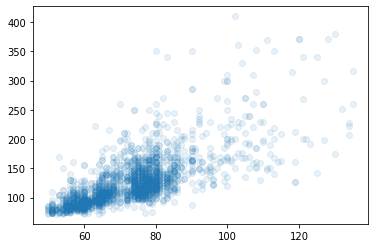

In [41]:
plt.scatter(data['totsp'], data['price'], alpha=0.1)
pass

Точки выстроились более-менее внутри конуса, носик которого находится в точке (0,0), а тело лежит на медиане первого квадранта координатной плоскости. Если сказать совсем грубо, то можно на этом графике заметить, что в некотором приближении зависимость стоимости квартиры от ее площади линейная.

Отрисовка всех точек требует много времени. Тем более, точки накладываются друг на друга и сложно понять сколько точек на том или ином участке графика (особенно, если не использовать параметр `alpha`). Поэтому изобразим только $1000$ случайных точек, что будет в нашем случае составлять примерно половину от их общего числа:

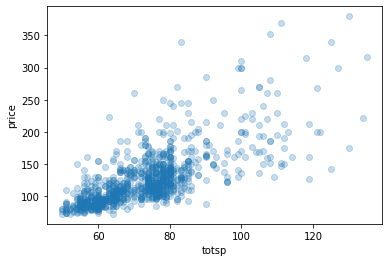

In [45]:
np.random.seed(42)
random_subset = np.random.choice(np.arange(data.shape[0]), size=1000, replace=False)
plt.scatter(data.iloc[random_subset]['totsp'], data.iloc[random_subset]['price'], alpha=0.25)
plt.xlabel('totsp')
plt.ylabel('price')
pass

Построим диаграмму рассеивания для признаков `'price'` и `'metrdist'`:

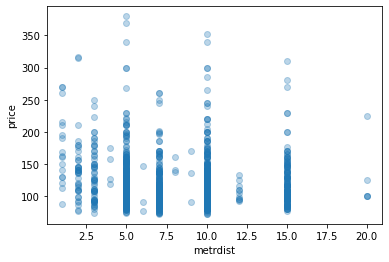

In [55]:
plt.scatter(data.iloc[random_subset]['metrdist'], data.iloc[random_subset]['price'], alpha = 0.3)
plt.xlabel('metrdist')
plt.ylabel('price')
pass

Из рисунка понятно, что, по-видимому, никакой зависимости между ценой и расстоянием до метро в Москве нет.
Однако видно, что точки сгущаются у определенных значений расстояния до мтеро, таких как: 5, 7, 10 и 15 минут ходьбы.

Для отрисовки диаграммы рассеивания мы можем воспользоваться более продвинутой функцией `scatterplot` из модуля `seaborn`. Например, в следующей диаграмме цвет маркеров соответствует типу этажа в доме `'floor'`, а размер - по расстоянию в минутах до метро `'metrdist'`:

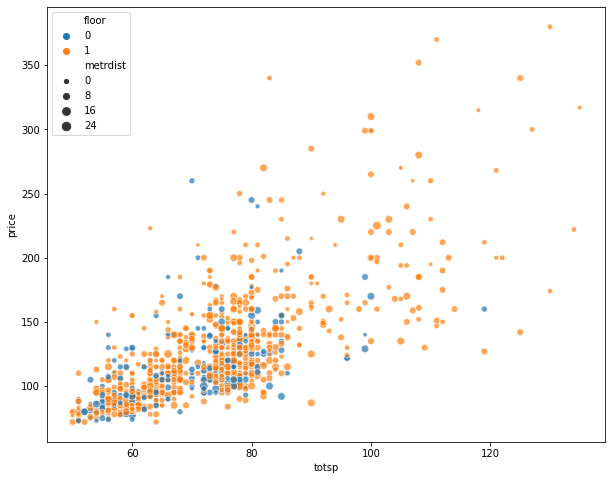

In [65]:
plt.figure(figsize = (10, 8))
sns.scatterplot(x='totsp', y='price', size='metrdist', hue='floor', data=data.iloc[random_subset], alpha=0.7)
pass